# <span style="color:blue"> Linear regression, model validation and gradient descent </span>

**by Anton Gusarov, gusarov@kth.se**

In [1]:
    %matplotlib inline
    %config InlineBackend.figure_format = 'retina' # For retina screens to have better quality of plots

    import numpy as np
    import matplotlib
    from matplotlib import pyplot as plt
    import sklearn

## <span style="color:blue"> 1. Simple linear regression with polynomial expansion </span>

### 1.1. Data generation
A noisy dataset of $m=100$ instances with a quadratic feature, then plot. Noise is additive: $n \sim \mathcal{N}(0,0.04)$.

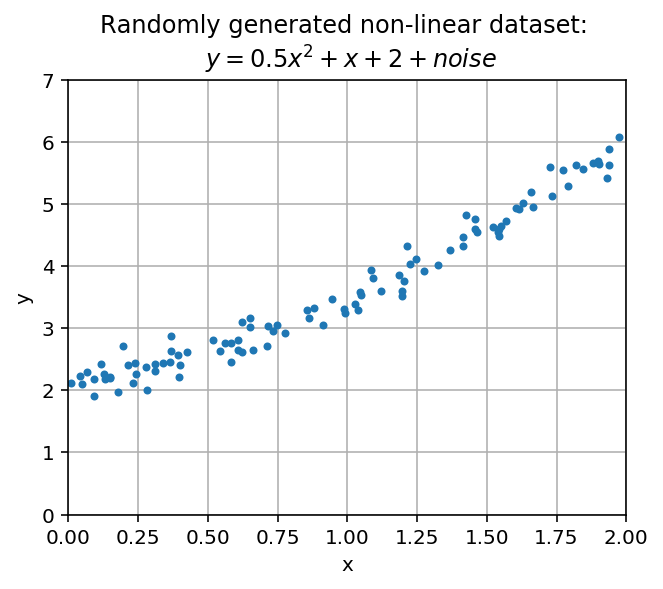

In [2]:
np.random.seed(42)  # for reproducibility

m = 100
x = 2 * np.random.rand(m,1)  # column-vector with m = 100 uniformly distributed random variables [0..2)
y = 0.5*x**2 + x + 2 + 0.2*np.random.randn(m,1)  # intercept is added i.e. not centered data

fig_1 = plt.figure(1, figsize=(5,4))
plt.plot(x, y, marker='.', linestyle=' ')

plt.axis([0,2, 0,7])
plt.title('Randomly generated non-linear dataset: \n $y=0.5x^2+x+2+noise$')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

### 1.2. LSE using the normal equation explicitly 

In [3]:
from sklearn.metrics import mean_squared_error

# Construct design matrix with polynomial expansion:
x_design = np.c_[np.power(x,2), x, np.ones((m,1))]
print('Design matrix: \n', 
       x_design[:6], '\n', 
       '...','\n') 

# matrix to be inverted in the normal equation:
print('XtX: \n', x_design.T.dot(x_design))

# Show that this is a full-rank matrix:
print('\nRank of XtX:', np.linalg.matrix_rank(x_design.T.dot(x_design)))

Design matrix: 
 [[0.5611212  0.74908024 1.        ]
 [3.61543077 1.90142861 1.        ]
 [2.14326052 1.46398788 1.        ]
 [1.43356792 1.19731697 1.        ]
 [0.09736726 0.31203728 1.        ]
 [0.09733716 0.31198904 1.        ]] 
 ... 

XtX: 
 [[293.99292941 184.33882041 123.47395265]
 [184.33882041 123.47395265  94.03614868]
 [123.47395265  94.03614868 100.        ]]

Rank of XtX: 3


In [4]:
# Solution of the normal equation:
theta_opt = np.linalg.inv(x_design.T.dot(x_design)).dot(x_design.T).dot(y)

# Print estimated coefficients compared with the true ones:
theta_true = [0.5, 1, 2]

print('Polynimial coefficients:')
print('Pow.', 'Estimated', ' True')
for i, (opt, true) in enumerate(zip(theta_opt, theta_true)):
    print(f'{len(theta_true)-1 - i}    {opt[0]:.3f}       {true}')

score_norm_eq = mean_squared_error(x_design.dot(theta_opt), y)
print(f'\nMSE score: {score_norm_eq:.4f}')

Polynimial coefficients:
Pow. Estimated  True
2    0.616       0.5
1    0.728       1
0    2.112       2

MSE score: 0.0311


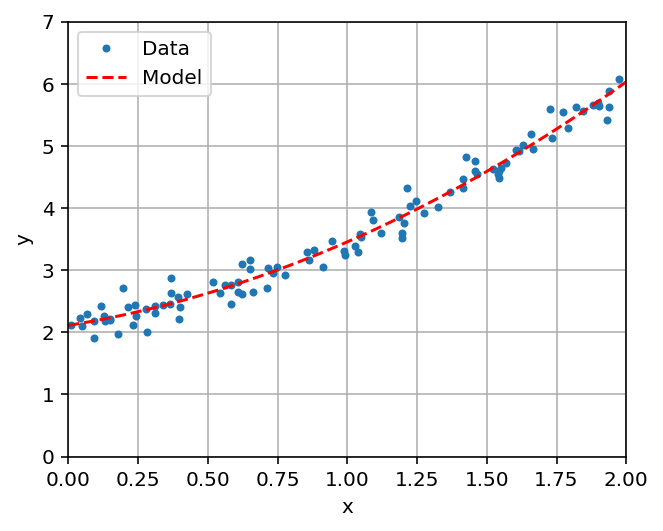

In [5]:
# Plot the fitted model vs data
# Define a polynomial class poly1d with coefficients being our theta_opt:
poly = np.poly1d(theta_opt.ravel())  

fig_2 = plt.figure(1, figsize=(5,4))
x_ = np.linspace(0,2,m) 

plt.plot(x, y, marker='.', linestyle=' ', label = 'Data')
plt.plot(x_, poly(x_), '--r',  label = 'Model')

plt.axis([0,2, 0,7])
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend(loc='best')

plt.show()

## <span style="color:blue"> 2. Polynomial regression on various datasets </span>

Illustrate the bias-variance tradeoff on the polynomial regression models of different compplexity. Trying different order, we can show best from the BV point of view model complexity. The dataset is split using 60% of data to train the model.

DATASET2.DAT 

Model order: 1
MSE_train: 8.2366
MSE_valid: 5.9776

Model order: 2
MSE_train: 4.9664
MSE_valid: 3.8900

Model order: 3
MSE_train: 3.8776
MSE_valid: 2.1602

Model order: 4
MSE_train: 3.8740
MSE_valid: 2.2032

Model order: 5
MSE_train: 3.8681
MSE_valid: 2.2475

Model order: 20
MSE_train: 3.3633
MSE_valid: 3.5425



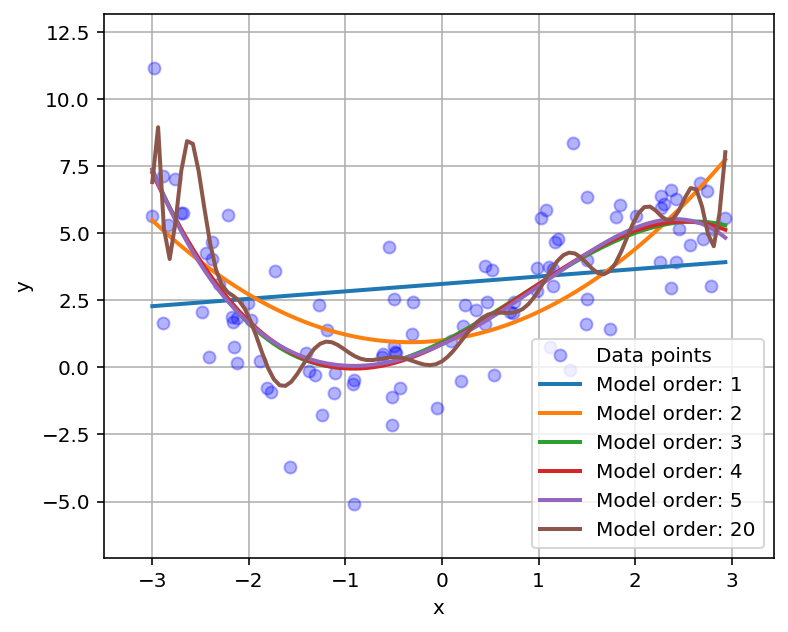

DATASET1.DAT 

Model order: 1
MSE_train: 3.9993
MSE_valid: 3.1513

Model order: 2
MSE_train: 1.4028
MSE_valid: 1.2783

Model order: 3
MSE_train: 0.2423
MSE_valid: 0.1350

Model order: 4
MSE_train: 0.2421
MSE_valid: 0.1377

Model order: 5
MSE_train: 0.2418
MSE_valid: 0.1405

Model order: 20
MSE_train: 0.2102
MSE_valid: 0.2214



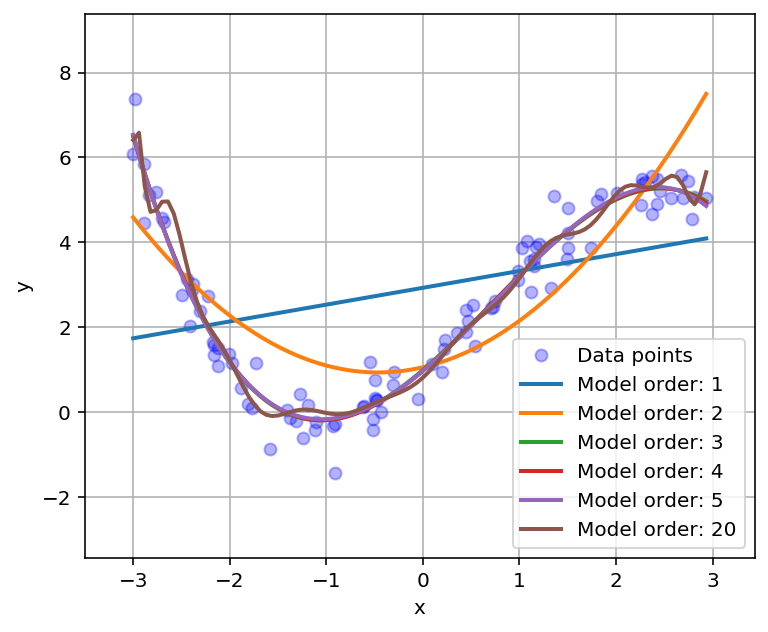

In [6]:
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def poly_regression_pipeline(X, y, file, train_proportion=0.6, model_orders=[1, 2, 3, 4, 5, 20]):
    """This function accepts data, trains polynomial regression of different orders, then calculates MSE
       both on validation and training dataset. Finally, plots the original dataset vs fitted model.
    """
    print(file.upper(),'\n') # print currently processing dataset
    
    # Make 2D array:
    X = X.reshape(-1, 1)
    y = y.reshape(-1, 1)
    
    # Splitting the dataset into train and validation subsets (sklearn function):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=train_proportion, random_state=42)

    # Plot data:
    plt.figure(1, figsize=(6,5))
    plt.plot(X, y, 'bo', linestyle=' ', label='Data points', alpha = 0.3)

    for order in model_orders:
        # Generate polynomial and interaction features:
        poly_features = PolynomialFeatures(degree=order, include_bias=False)
        X_ = np.linspace(np.amin(X), np.amax(X), len(X)).reshape(-1,1)

        X_poly = poly_features.fit_transform(X_)
        X_train_poly = poly_features.fit_transform(X_train)
        X_valid_poly = poly_features.fit_transform(X_valid)

        # Fit a linear regression over polynomial features:
        lin_reg = LinearRegression()
        lin_reg.fit(X_train_poly, y_train)
        
        print(f'Model order: {order}')
       # print(f'Model order: {order} \nIntercept: {lin_reg.intercept_[0]} \nCoefficients: {lin_reg.coef_}')

        y_train_predict = lin_reg.predict(X_train_poly)
        y_valid_predict = lin_reg.predict(X_valid_poly)
        y_predict = lin_reg.predict(X_poly)

        print(f'MSE_train: {mean_squared_error(y_train, y_train_predict):.4f}')
        print(f'MSE_valid: {mean_squared_error(y_valid, y_valid_predict):.4f}\n')

        # Plot model line:
        plt.plot(X_, y_predict, linewidth=2, label=f'Model order: {order}')

    plt.axis([np.amin(X)-0.5, np.amax(X)+0.5, 
              np.amin(y)-2, np.amax(y)+2])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.legend()
    plt.savefig('Plot_2.jpg', transparent='True', dpi=840)  # MUST be called before show() 
    plt.show()
    
    return None


# Apply the defined above function to all the datasets:
for file in os.listdir('DataFiles/')[1:]:
    X, y = np.loadtxt(f'DataFiles/{file}', unpack=True)
    poly_regression_pipeline(X, y, file)
    

Based on the minimal MSE for validation dataset:
* `dataset1.dat`: model of **order 3** is the best;
* `dataset2.dat`: model of **order 3** is the best;

## <span style="color:blue"> 3. k-fold cross-validation </span>

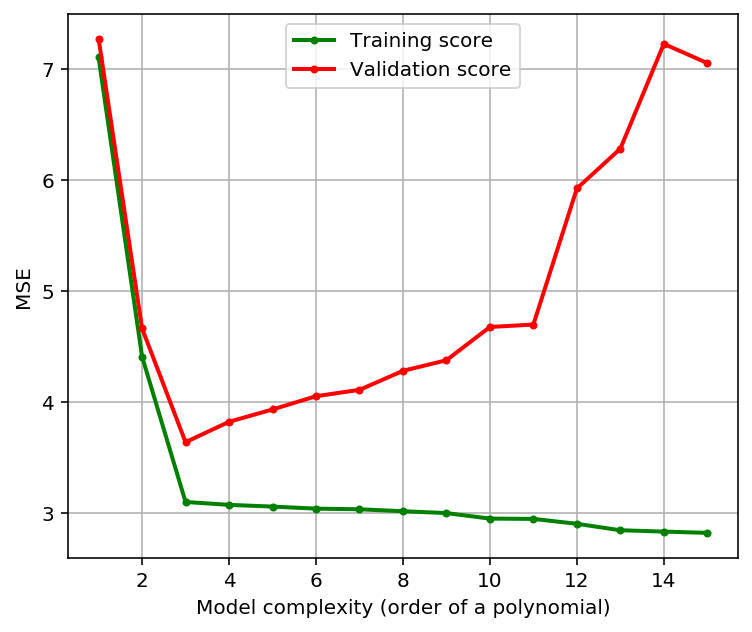

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import statistics

def calculate_scores(X, y, model_orders, num_folds=5):
    
    # Reshape into 2D array:
    X = X.reshape(-1, 1)
    y = y.reshape(-1, 1)
        
    # Split dataset into folds:            
    X_folds = np.array_split(X, num_folds)
    y_folds = np.array_split(y, num_folds)
    
    score_train_order, score_valid_order = [], []      
    for order in model_orders:
        
        score_train_k, score_valid_k = [], []  
        for k in range(num_folds):
            X_valid = np.array(X_folds[k])
            y_valid = np.array(y_folds[k])
            
            y_folds_copy = y_folds.copy()
            X_folds_copy = X_folds.copy()
            
            del y_folds_copy[k], X_folds_copy[k]     
            X_train = np.vstack(( X_folds_copy ))
            y_train = np.vstack(( y_folds_copy ))

            # Generate polynomial and interaction features:
            poly_features = PolynomialFeatures(degree=order, include_bias=False)
            X_train_poly = poly_features.fit_transform(X_train)
            X_valid_poly = poly_features.fit_transform(X_valid)

            # Define and fit a linear regression model over polynomial features:
            lin_reg = LinearRegression()
            lin_reg.fit(X_train_poly, y_train)

            y_train_predict = lin_reg.predict(X_train_poly)
            y_valid_predict = lin_reg.predict(X_valid_poly)
            
            # Accumulate scores per each fold:
            score_train_k.append(mean_squared_error(y_train, y_train_predict)) 
            score_valid_k.append(mean_squared_error(y_valid, y_valid_predict)) 
            
        # Accumulate averaged scores over the folds per order:  
        score_train_order.append(statistics.mean(score_train_k))  
        score_valid_order.append(statistics.mean(score_valid_k))
          
    return score_train_order, score_valid_order


X, y = np.loadtxt('DataFiles/dataset2.dat', unpack=True)
orders = range(1,16)
MSE_train, MSE_valid = calculate_scores(X, y, model_orders=orders)

# Plot the scores - validation curves:
plt.figure(1, figsize=(6,5))
plt.plot(orders, MSE_train, '-g.', linewidth=2, label='Training score')
plt.plot(orders, MSE_valid, '-r.', linewidth=2, label='Validation score')
plt.xlabel('Model complexity (order of a polynomial)')
plt.ylabel('MSE')
plt.grid(True)
plt.legend()
plt.show()
# To save the plot:
# plt.savefig('Plot_1.jpg', transparent='True', dpi=840)  # MUST be called before show() 

In [ ]:
print(MSE_train, '\n')
print(MSE_valid)

* Polynomial of the order 3 is the best choice.

## <span style="color:blue"> 4. Convergence of the gradient descent </span>

In [8]:
# Regenerate data from the section 1:
np.random.seed(42)  # for reproducibility

m = 100
x = 2*np.random.rand(m,1)  # column-vector with 100 uniformly distributed r.v. [0..2)
y = 0.5*x**2 + x + 2 + 0.2*np.random.randn(m,1)  # intercept is added i.e. not centered data
y = y.reshape(-1,1)


### Batch gradient descent, BGD

  $$\nabla_{\theta}MSE(\theta) = \frac{2}{m}X^T(X\theta-y)$$

  $$\theta^{(next step)} = \theta - \eta \nabla_{\theta}MSE(\theta)$$

This is calculated over the **whole training dataset - batch**.  
Implement the BGD solution:

In [9]:
%%time 

# Construct design matrix for polynomial features
x_design = np.c_[np.power(x,2), x, np.ones((m,1))]

#eta = 0.194    # learning rate, tuned separately below - best fit
eta = 0.1    # learning rate, tuned separately below - ood fit, smooth learning trajectory
n_epochs = 50  # stop condition is simply a number of iterations

# theta = np.random.randn(3,1)  # random initialization of model parameters
theta_bgd = np.zeros((3,1))  # zero initialization, works well in this case

print('theta initial:\n', theta_bgd.ravel(), '\n')
for iteration in range(n_epochs):
    nabla = 2/m * (x_design.T).dot(x_design.dot(theta_bgd[:,(-1)].reshape(3,1)) - y)
    theta_bgd = np.hstack(( theta_bgd, (theta_bgd[:,(-1)].reshape(3,1) - eta*nabla) ))  # accumulate values of thetas
        
    if  iteration == (n_epochs-1):
        print('nabla:\n', nabla.ravel(), '\n')
        print('theta final:\n', theta_bgd[:,(-1)], '\n')
        
score_bgd = mean_squared_error(x_design.dot(theta_bgd[:,(-1)]), y)
print('\nMSE score norm eq.:', score_norm_eq)  # score from solution via normal equation
print('MSE score BGD:     ', score_bgd)


theta initial:
 [0. 0. 0.] 

nabla:
 [ 0.00712676  0.00463633 -0.02062689] 

theta final:
 [0.5339787  0.92030864 2.02320107] 


MSE score norm eq.: 0.031087746654009468
MSE score BGD:      0.032136669214496254
CPU times: user 4.09 ms, sys: 2.06 ms, total: 6.15 ms
Wall time: 4.34 ms


* Plot the search trajectory for **BGD** in a 3D space of parameters $\theta$:

In [10]:
def plot_search_trajectory(theta):
    """ This function plots the search trajectory for BGD in a 3D space of parameters 
    """
    from mpl_toolkits.mplot3d import Axes3D
    
    fig = plt.figure(1, figsize=(7,6))
    # ax = fig.gca(projection='3d')
    ax= fig.add_subplot(111, projection= '3d')

    theta_x = theta[(0),...]
    theta_y = theta[(1),...]
    theta_z = theta[(2),...]

    ax.plot(theta_x, theta_y, 'grey', zdir='theta_z', label='Projection')
    
    ax.plot(theta_x, 
            theta_y, 
            theta_z,'r.-', label='Search curve')
    ax.legend()
    ax.set_xlabel('theta 1', fontsize = 12)
    ax.set_ylabel('theta 2', fontsize = 12)
    ax.set_zlabel('theta 3', fontsize = 12)
    plt.show()
        
    return None

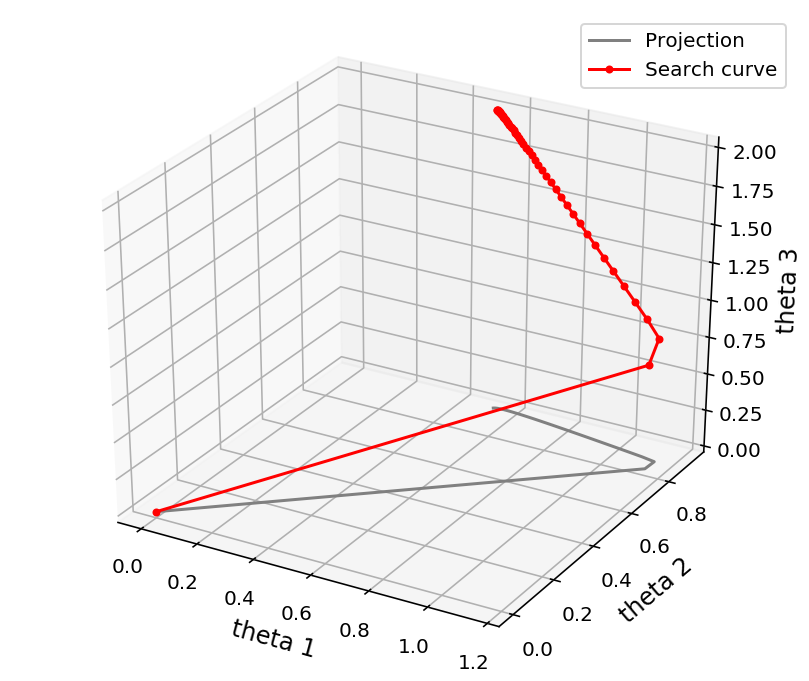

In [11]:
plot_search_trajectory(theta_bgd)

* Tune the learning rate hyperparameter $\eta$ for BGD:

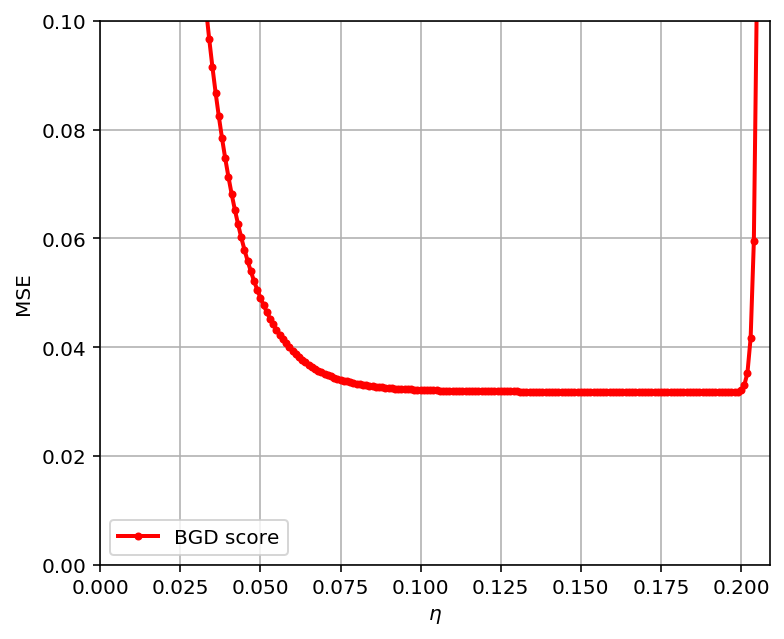

In [12]:
eta_vect = np.arange(0, 0.21, 0.001)
score_bgd_tune = []

for eta in eta_vect:
    # theta = np.random.randn(3,1)  # random initialization of model parameters
    theta = np.zeros((3,1))  # zero initialization, works well in this case

    for iteration in range(n_epochs):
        nabla = 2/m * (x_design.T).dot(x_design.dot(theta) - y)
        theta = theta - eta*nabla

    score_bgd_tune.append(mean_squared_error(x_design.dot(theta), y)) # final BGD score for specific eta

# Plot scores:
plt.figure(1, figsize=(6,5))
plt.plot(eta_vect, score_bgd_tune, '-r.', linewidth=2, label='BGD score')
plt.xlabel('$\eta$')
plt.ylabel('MSE')
plt.grid(True)
plt.legend()
plt.axis([0,np.amax(eta_vect), 0, 0.1])
plt.show()


### Stochastic gradient descent, SGD

In [13]:
%%time

m = 100  # length of a dataset
n_epochs = 50  # stop condition is simply a number of iterations

# Construct design matrix for polynomial features
x_design = np.c_[np.power(x,2), x, np.ones((m,1))]

t0, t1 = 6, 70  # hyperpaprametrs of a learning schedule
def learning_schedule(t): 
    return t0 / (t + t1)

# theta = np.random.randn(3,1)  # random initialization of model parameters
theta_sgd = np.zeros((3,1))  # zero initialization, works well in this case

print('theta initial:\n', theta_sgd.ravel(), '\n')

for epoch in range(n_epochs):
    for i in range(m):
        
        # Take a random INSTANCE of a training set:
        random_index = np.random.randint(m)  # random int m = 0...99
        x_design_i = x_design[random_index:random_index+1, :]
        y_i = y[random_index:random_index+1, :]
        
        nabla = 2 * (x_design_i.T).dot(x_design_i.dot(theta_sgd[:,(-1)].reshape(3,1)) - y_i)
        eta = learning_schedule(epoch*m + i)  # learning schedule applied
        theta_sgd = np.hstack(( theta_sgd, (theta_sgd[:,(-1)].reshape(3,1) - eta*nabla) ))  # accumulate values of thetas

    if  epoch == (n_epochs-1):
        print('nabla:\n', nabla.ravel(), '\n')
        print('theta final:\n', theta_sgd[:,(-1)], '\n')
        
score_sgd = mean_squared_error(x_design.dot(theta_sgd[:,(-1)]), y)
print('\nMSE score norm eq.:', score_norm_eq)  # score from solution via normal equation
print('MSE score BGD:     ', score_bgd)
print('MSE score SGD:     ', score_sgd, '\n')


theta initial:
 [0. 0. 0.] 

nabla:
 [-0.02630432 -0.06710873 -0.1712107 ] 

theta final:
 [0.52651538 0.89057584 2.04816848] 


MSE score norm eq.: 0.031087746654009468
MSE score BGD:      0.032136669214496254
MSE score SGD:      0.03231123582407547 

CPU times: user 112 ms, sys: 9.16 ms, total: 121 ms
Wall time: 117 ms


* Plot the search trajectory for **SGD** in a 3D space of parameters $\theta$:

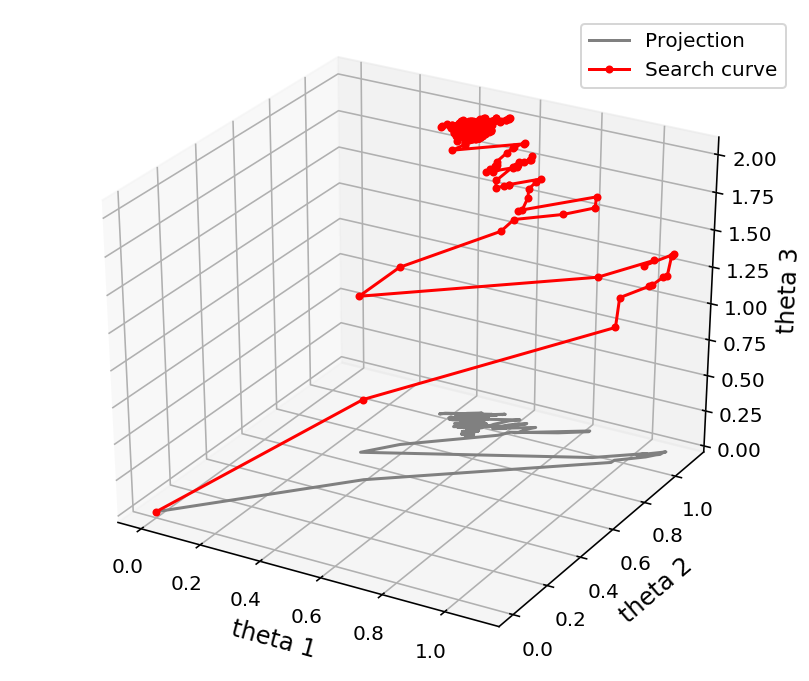

In [14]:
plot_search_trajectory(theta_sgd)

### Mini batch gradient descent, MGD

In [15]:
%%time

m = 100  # length of a dataset
n_epochs = 50  # stop condition is simply a number of iterations
mini_batch_size = 0.2

# Construct design matrix for polynomial features
x_design = np.c_[np.power(x,2), x, np.ones((m,1))]

t0, t1 = 10, 70  # hyperpaprametrs of a learning schedule
def learning_schedule(t): 
    return t0 / (t + t1)

# theta_mgd = np.random.randn(3,1)  # random initialization of model parameters
theta_mgd = np.zeros((3,1))  # zero initialization, works well in this case

print('theta initial:\n', theta_mgd.ravel(), '\n')

for epoch in range(n_epochs):
    for i in range(4):  # 5 iterations per epoch since we have 20% size of batch
        
        # Extract a mini batch:
        split_data = train_test_split(x_design, y, train_size=mini_batch_size, shuffle=True)
        x_design_i = split_data[0]
        y_i = split_data[2]
        
        # Solve:
        nabla = 2/(m*mini_batch_size) * (x_design_i.T).dot(x_design_i.dot(theta_mgd[:,(-1)].reshape(3,1)) - y_i)
        eta = learning_schedule(epoch*(m*mini_batch_size) + i)  # learning schedule applied
        theta_mgd = np.hstack(( theta_mgd, (theta_mgd[:,(-1)].reshape(3,1) - eta*nabla) ))  # accumulate values of thetas

    if  epoch == (n_epochs-1):
        print('nabla:\n', nabla.ravel(), '\n')
        print('theta final:\n', theta_mgd[:,(-1)], '\n')
        
score_mgd = mean_squared_error(x_design.dot(theta_mgd[:,(-1)]), y)
print('\nMSE score norm eq.:', score_norm_eq)  # score from solution via normal equation
print('MSE score BGD:     ', score_bgd)
print('MSE score SGD:     ', score_sgd,)
print('MSE score MGD:     ', score_mgd, '\n')

theta initial:
 [0. 0. 0.] 

nabla:
 [-0.00022493  0.02875269  0.05612052] 

theta final:
 [0.5141582  0.95776572 2.02313639] 


MSE score norm eq.: 0.031087746654009468
MSE score BGD:      0.032136669214496254
MSE score SGD:      0.03231123582407547
MSE score MGD:      0.032339116507424596 

CPU times: user 43 ms, sys: 2.57 ms, total: 45.6 ms
Wall time: 44.1 ms


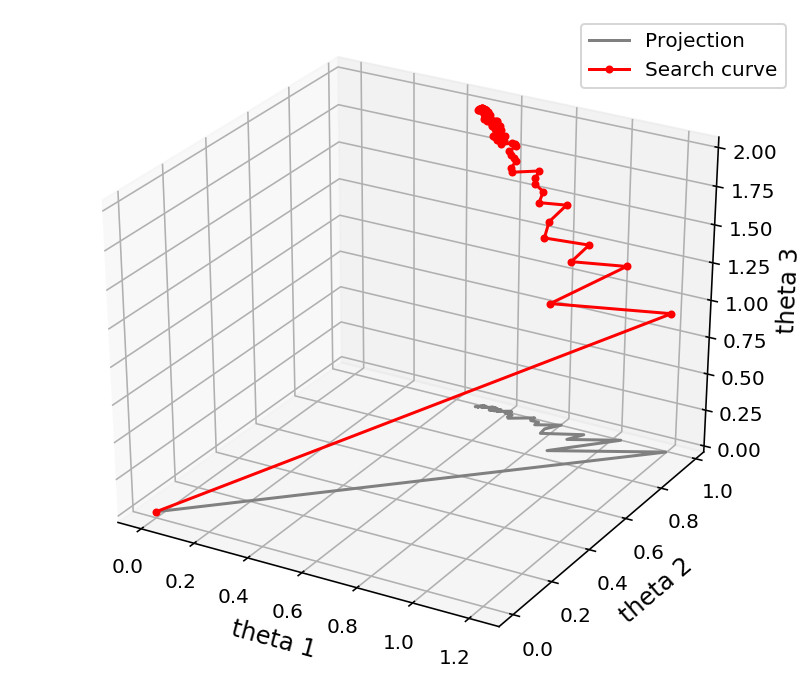

In [16]:
plot_search_trajectory(theta_mgd)

### Comparing convergence of different gradient descent modifications

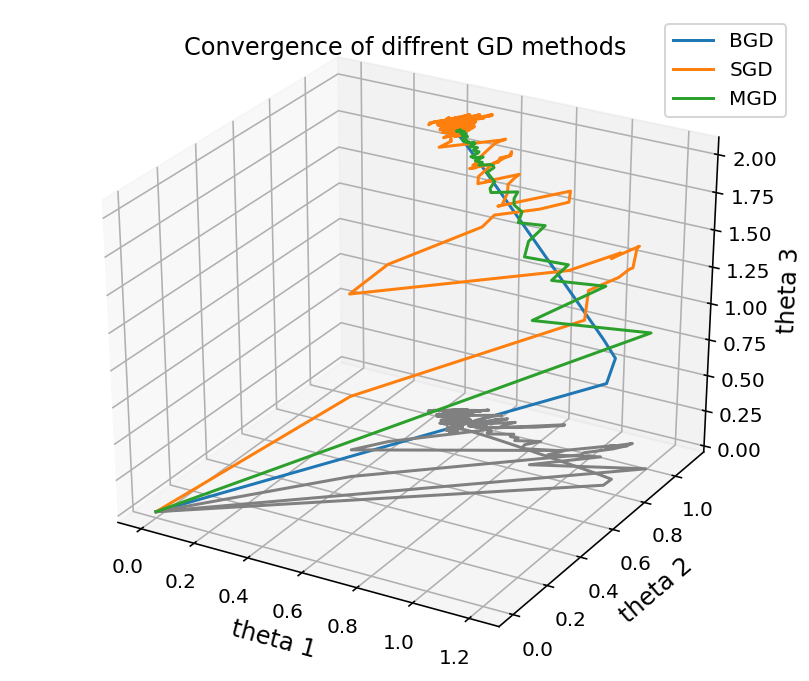

In [17]:
from mpl_toolkits.mplot3d import Axes3D

def plot_trajectory_curve(theta, curve_name):
    theta_x = theta[(0),...]
    theta_y = theta[(1),...]
    theta_z = theta[(2),...]
    ax.plot(theta_x, theta_y, 'grey', zdir='theta_z')
    ax.plot(theta_x, theta_y, theta_z, label=curve_name)
    return None


fig = plt.figure(1, figsize=(7,6))
ax= fig.add_subplot(111, projection= '3d')

# Plot all learning trajectories:
plot_trajectory_curve(theta_bgd, 'BGD')
plot_trajectory_curve(theta_sgd, 'SGD')
plot_trajectory_curve(theta_mgd, 'MGD')

ax.legend()
ax.set_title('Convergence of diffrent GD methods', fontsize = 12)
ax.set_xlabel('theta 1', fontsize = 12)
ax.set_ylabel('theta 2', fontsize = 12)
ax.set_zlabel('theta 3', fontsize = 12)

# plt.savefig('Plot_2.jpg', transparent='True', dpi=840)  # MUST be called before show() 
plt.show()